# Домашнее задание
## Провести полноценный анализ временного ряда с использованием Python по этапам, которые были рассказаны на лекции

Временной ряд будет представлять собой данные о ежедневной котировки акции (берем цену закрытия - CLOSE), торгующейся на Московской бирже в режиме основных торгов, за весь 2021 год.

Данные выгружаются отсюда:
    https://www.finam.ru/profile/moex-akcii/sberbank_sber-smal/export/?market=1

Пример настройки выгрузки:
    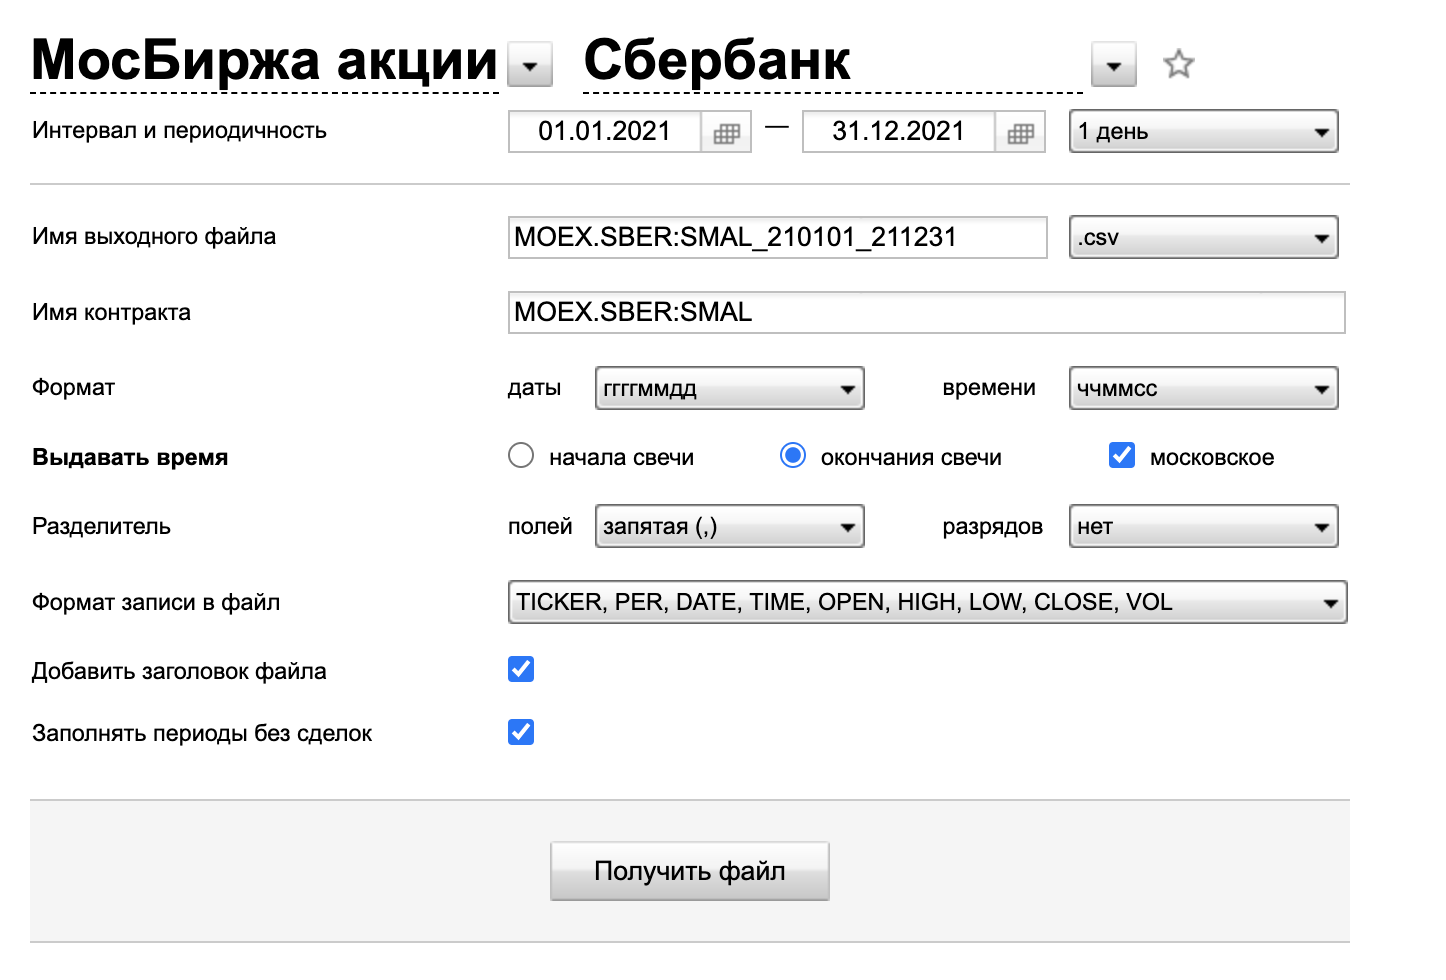

Выбранные акции НЕ должны повторяться между студентами. Свой выбор записываете в данную таблицу:
https://docs.google.com/spreadsheets/d/1LxrP99lMoFRYLgvCBYks-Ojbrc6KsPJr5RF43hS0qLE/edit?usp=sharing

К работе прикладываете файл с загруженными вами данными - без них работа не оценивается.

Каждый этап работы с временными рядами должен сопровождаться качественной интерпретацией результата.

Также вам необходимо осуществить предсказание временного ряда.

Изучите одну из базовых библиотек для прогнозирования - Prophet
https://facebook.github.io/prophet/docs/quick_start.html#python-api

Обучите модель на данных январь - ноябрь и сделайте предсказание на декабре. Оцените качество полученного результата.

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings
import datetime
from dateutil.relativedelta import relativedelta

In [2]:
df = pd.read_csv('GOOG.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format='%Y%m%d')
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GOOG-RM,D,2021-01-04,0,130050.0,130050.0,127000.0,127864.0,76
1,GOOG-RM,D,2021-01-05,0,128919.0,130001.0,128404.0,128404.0,72
2,GOOG-RM,D,2021-01-06,0,127795.0,128544.0,125250.0,128060.0,185
3,GOOG-RM,D,2021-01-08,0,131895.0,133707.0,130350.0,133707.0,303
4,GOOG-RM,D,2021-01-11,0,133953.0,134501.0,132118.0,132118.0,125
...,...,...,...,...,...,...,...,...,...
241,GOOG-RM,D,2021-12-23,0,216181.0,218131.0,215100.0,216493.0,68
242,GOOG-RM,D,2021-12-27,0,217134.0,218100.0,215790.0,217185.0,48
243,GOOG-RM,D,2021-12-28,0,219500.0,219500.0,215700.0,216288.0,59
244,GOOG-RM,D,2021-12-29,0,216981.0,217335.0,215919.0,217313.0,54


Разделим данные на train (январь - ноябрь) и test (декабрь)

In [3]:
x = '<DATE>'
target = '<CLOSE>'
df_train = df.loc[df[x]<np.datetime64('2021-12-01'), [x,target]]
df_train.columns=['ds','y']
df_train.set_index('ds')
df_test  = df.loc[df[x]>=np.datetime64('2021-12-01'), [x,target]]
df_test.columns=['ds','y']
df_test.set_index('ds')
df = df_train
x = 'ds'
target='y'

Построим график

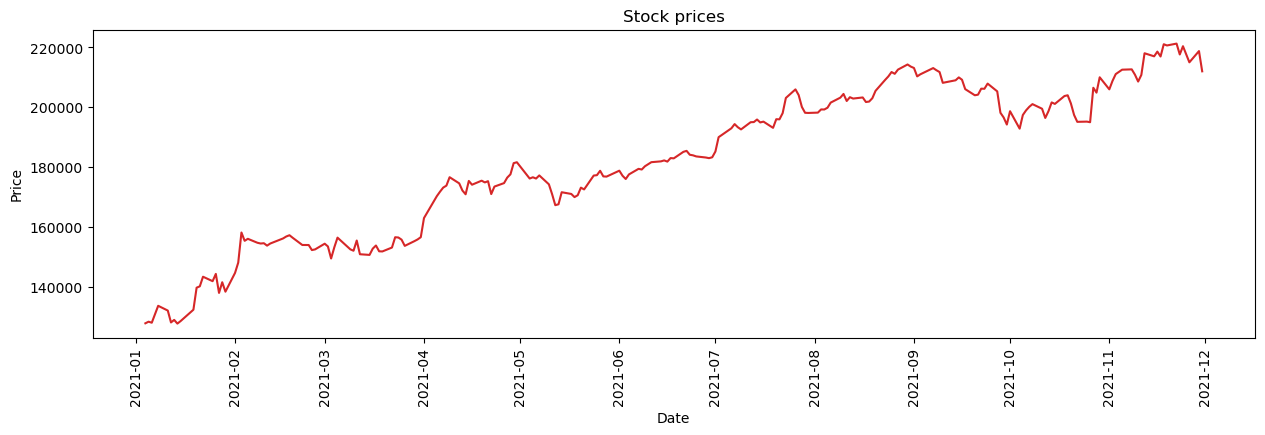

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Price', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.show()
    
plot_df(df, x=df[x], y=df[target], title='Stock prices')

Проведём аддитивную сезонную декомпозицию (не мультипликативную, т.к. визуально ряд не выглядит как мультипликативный, а скорее как аддитивный)

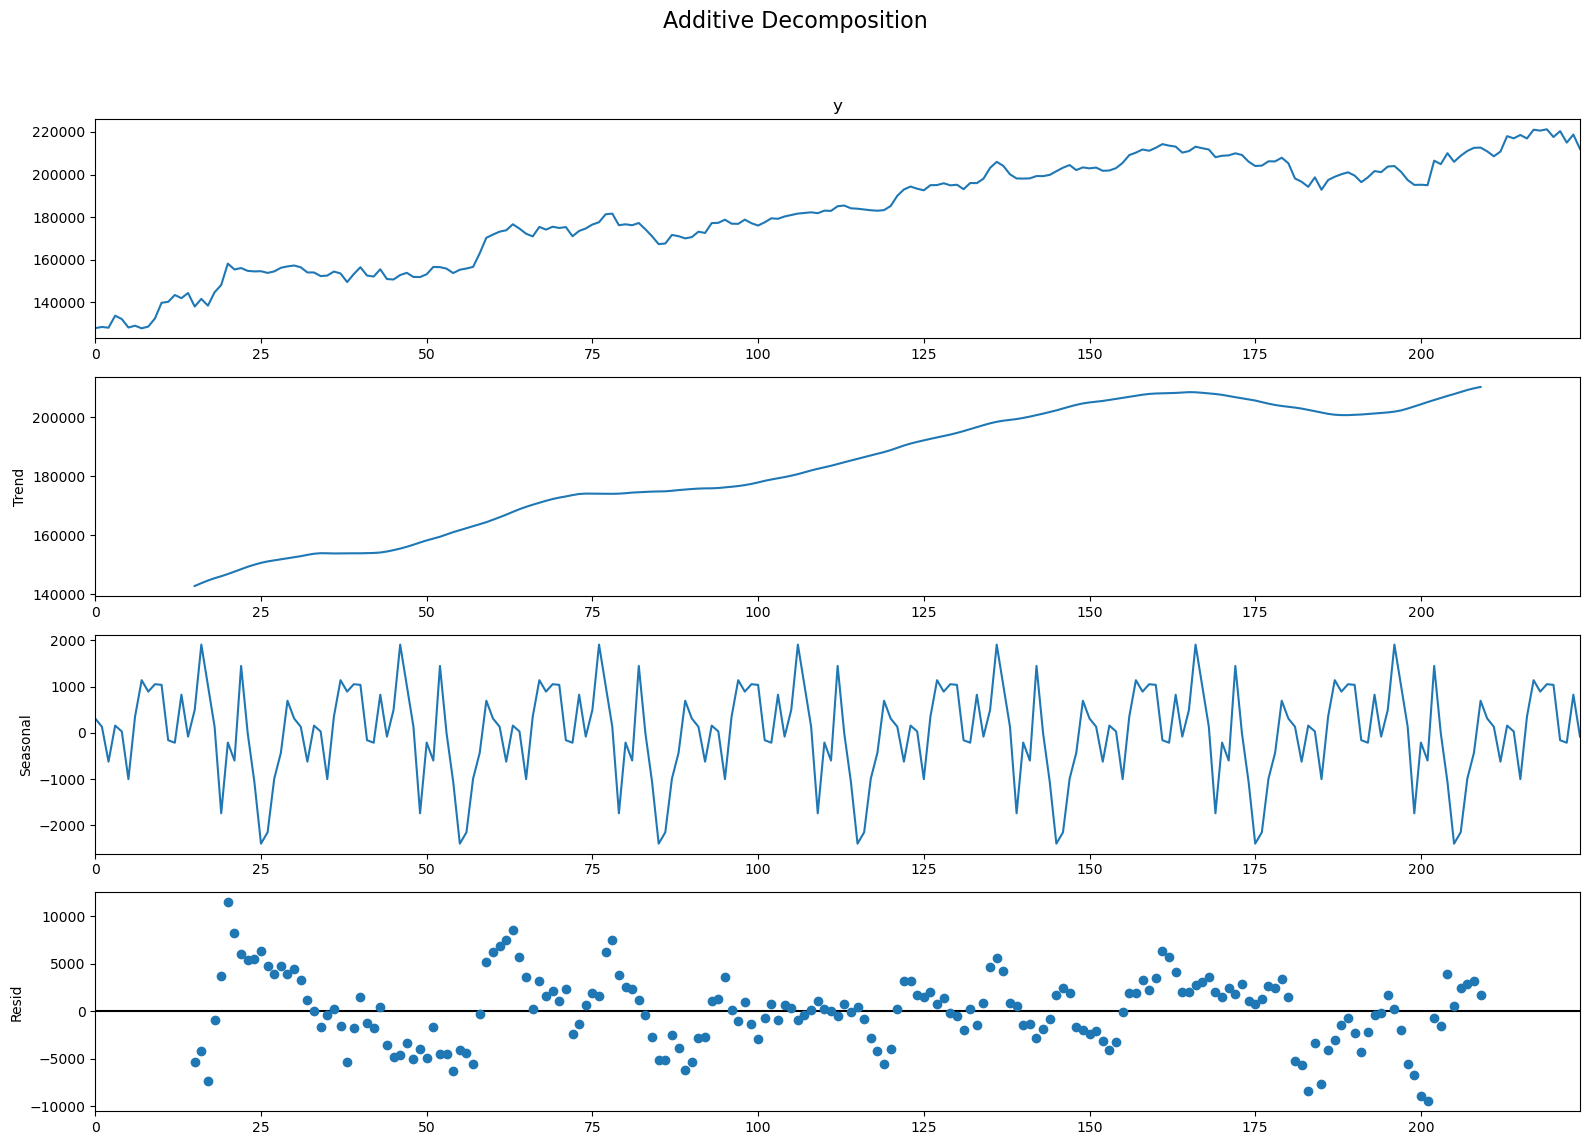

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

additive_decomposition = seasonal_decompose(df[target], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Судя по графику, в данных есть тренд, и есть сезонность с периодом 30 дней. Проведём сезонное дифференцирование, и проверим стационарность ряда критерем Дики-Фуллера

Критерий Дики-Фуллера: p=0.114329


<Figure size 1500x1000 with 0 Axes>

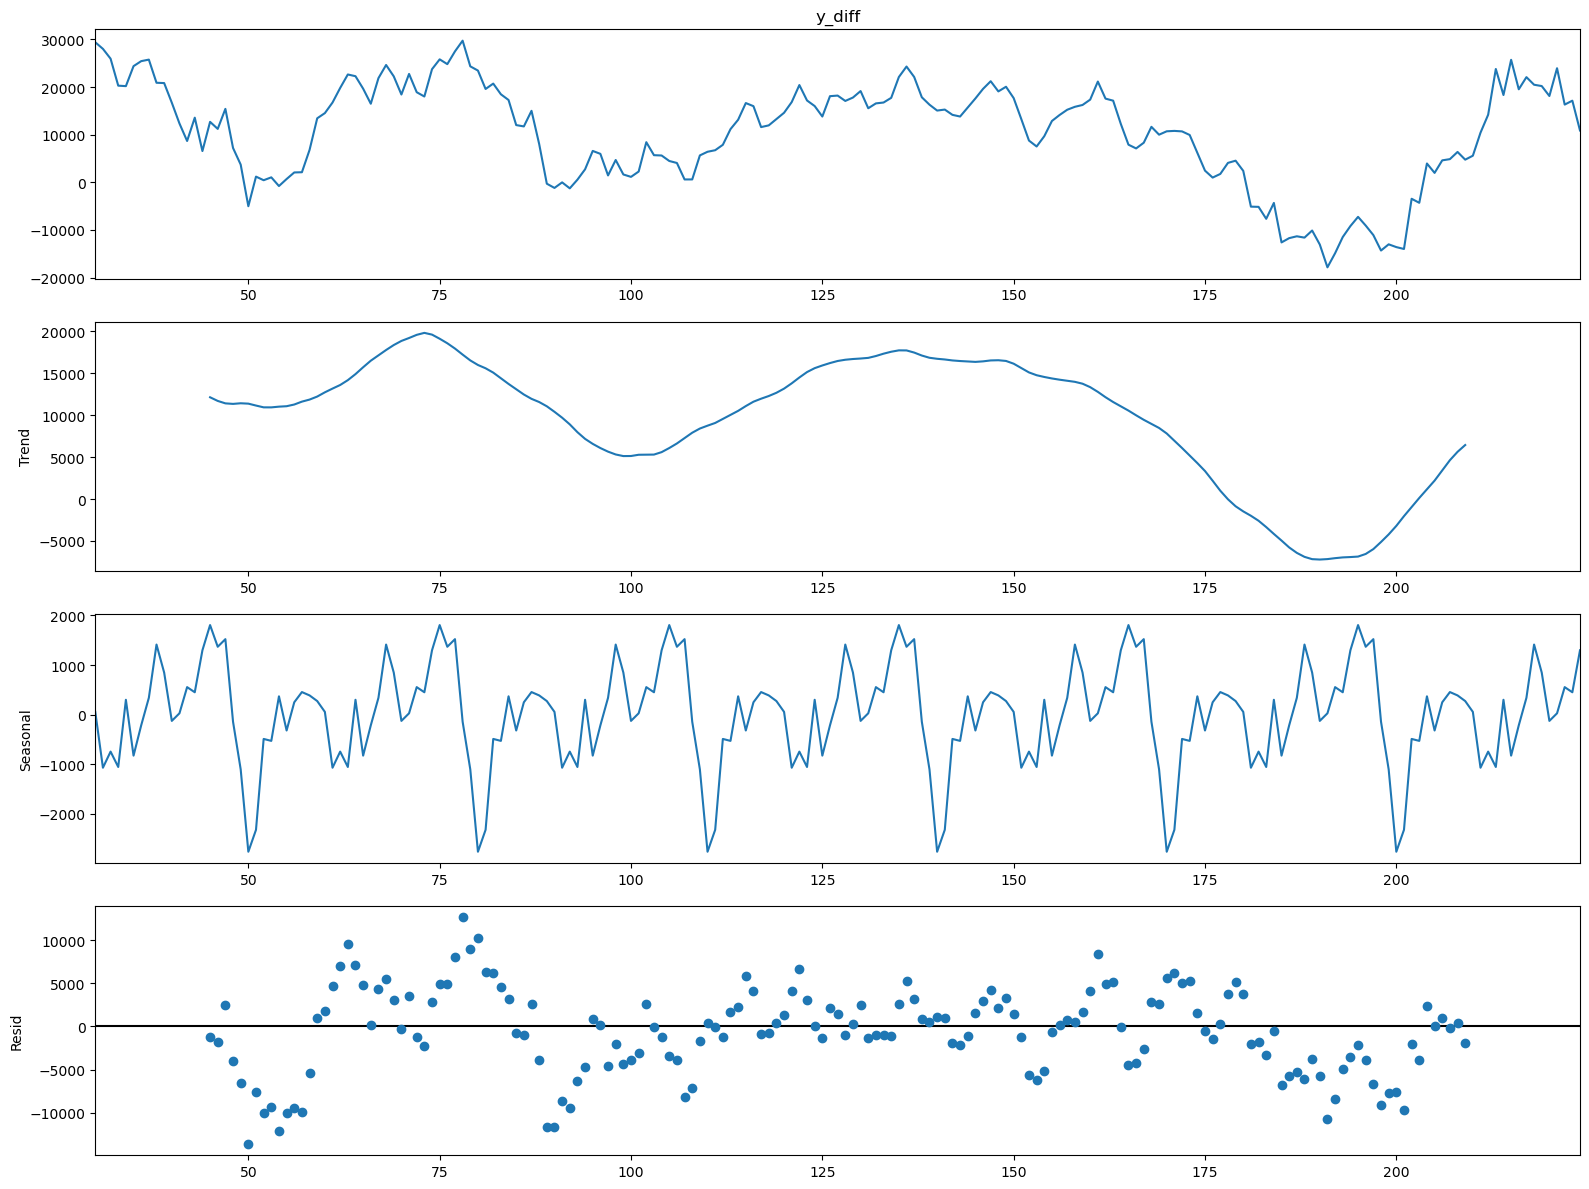

In [6]:
period = 30
df['y_diff'] = df[target] - df[target].shift(period)
target = 'y_diff'
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df[target][period:], period=period).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df[target][period:])[1])

Критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда. Попробуем дополнительно провести обычное дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1500x1000 with 0 Axes>

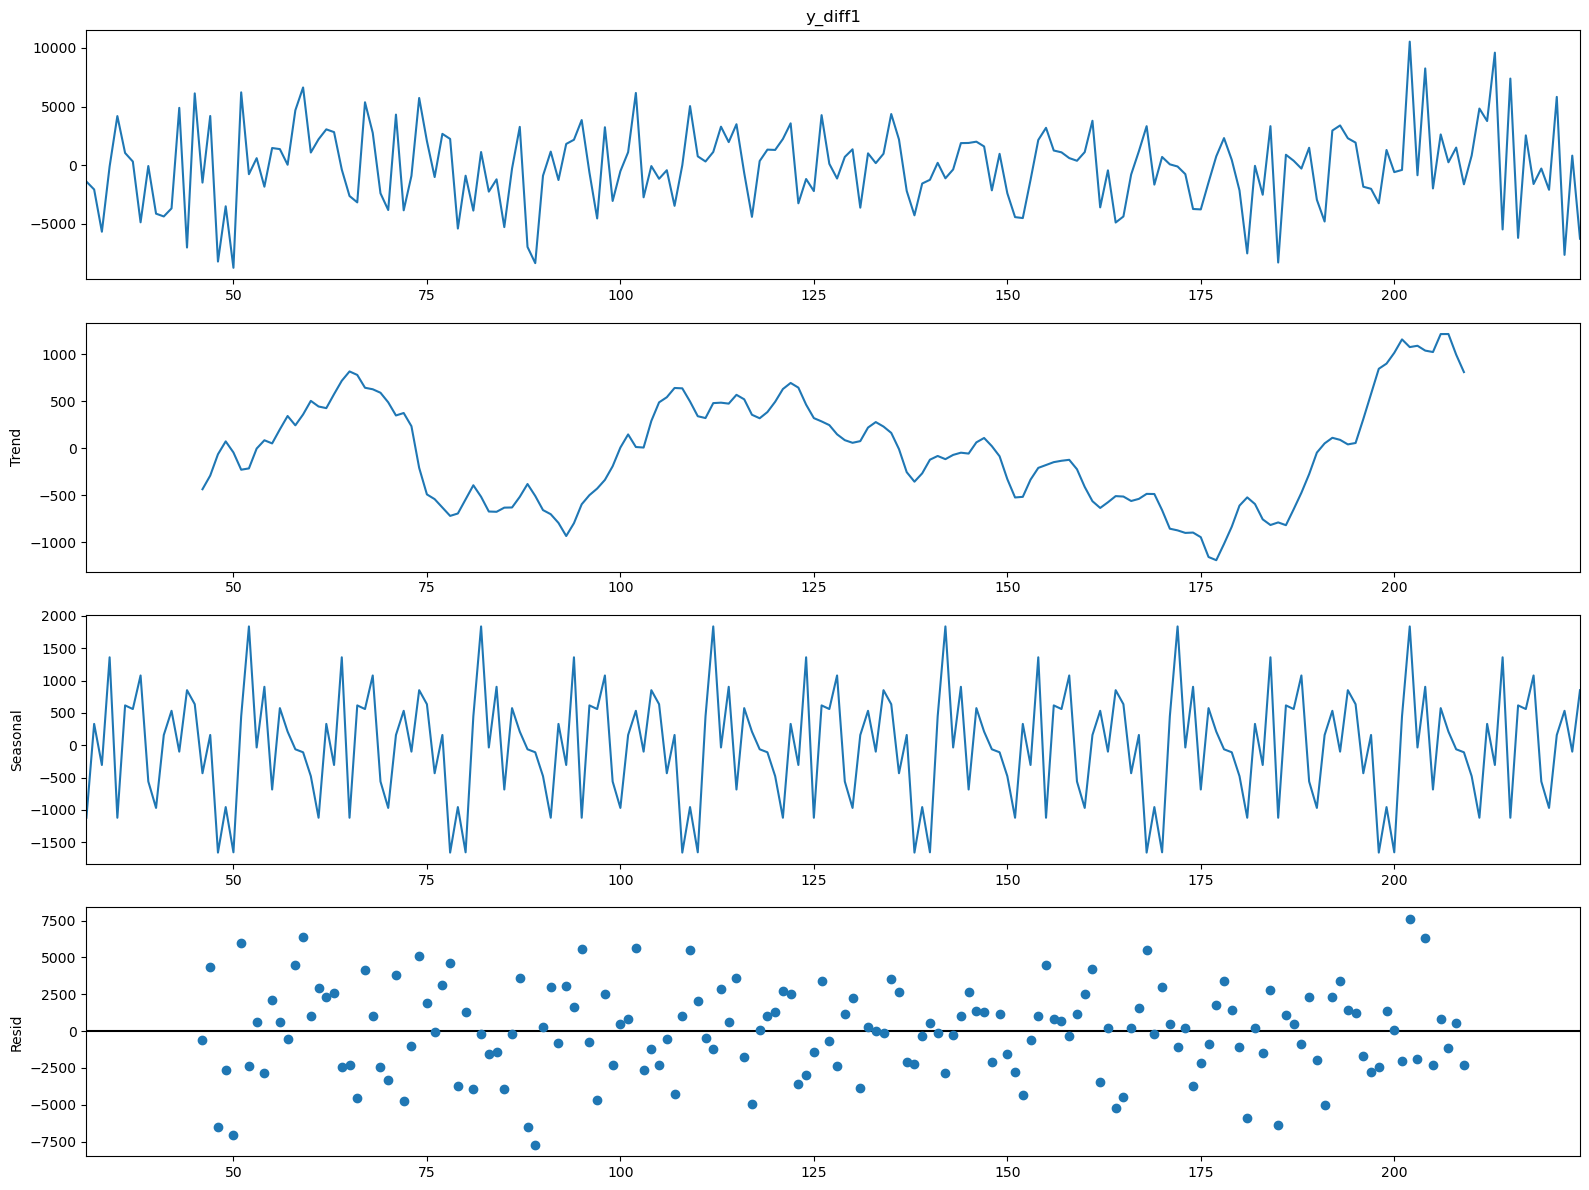

In [7]:
df['y_diff1'] = df[target] - df[target].shift(1)
target = 'y_diff1'
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df[target][period+1:], period=period).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df[target][period+1:])[1])

Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда, но по графику видно, что избавиться от тренда полностью не удалось. Проведём еще одно дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1500x1000 with 0 Axes>

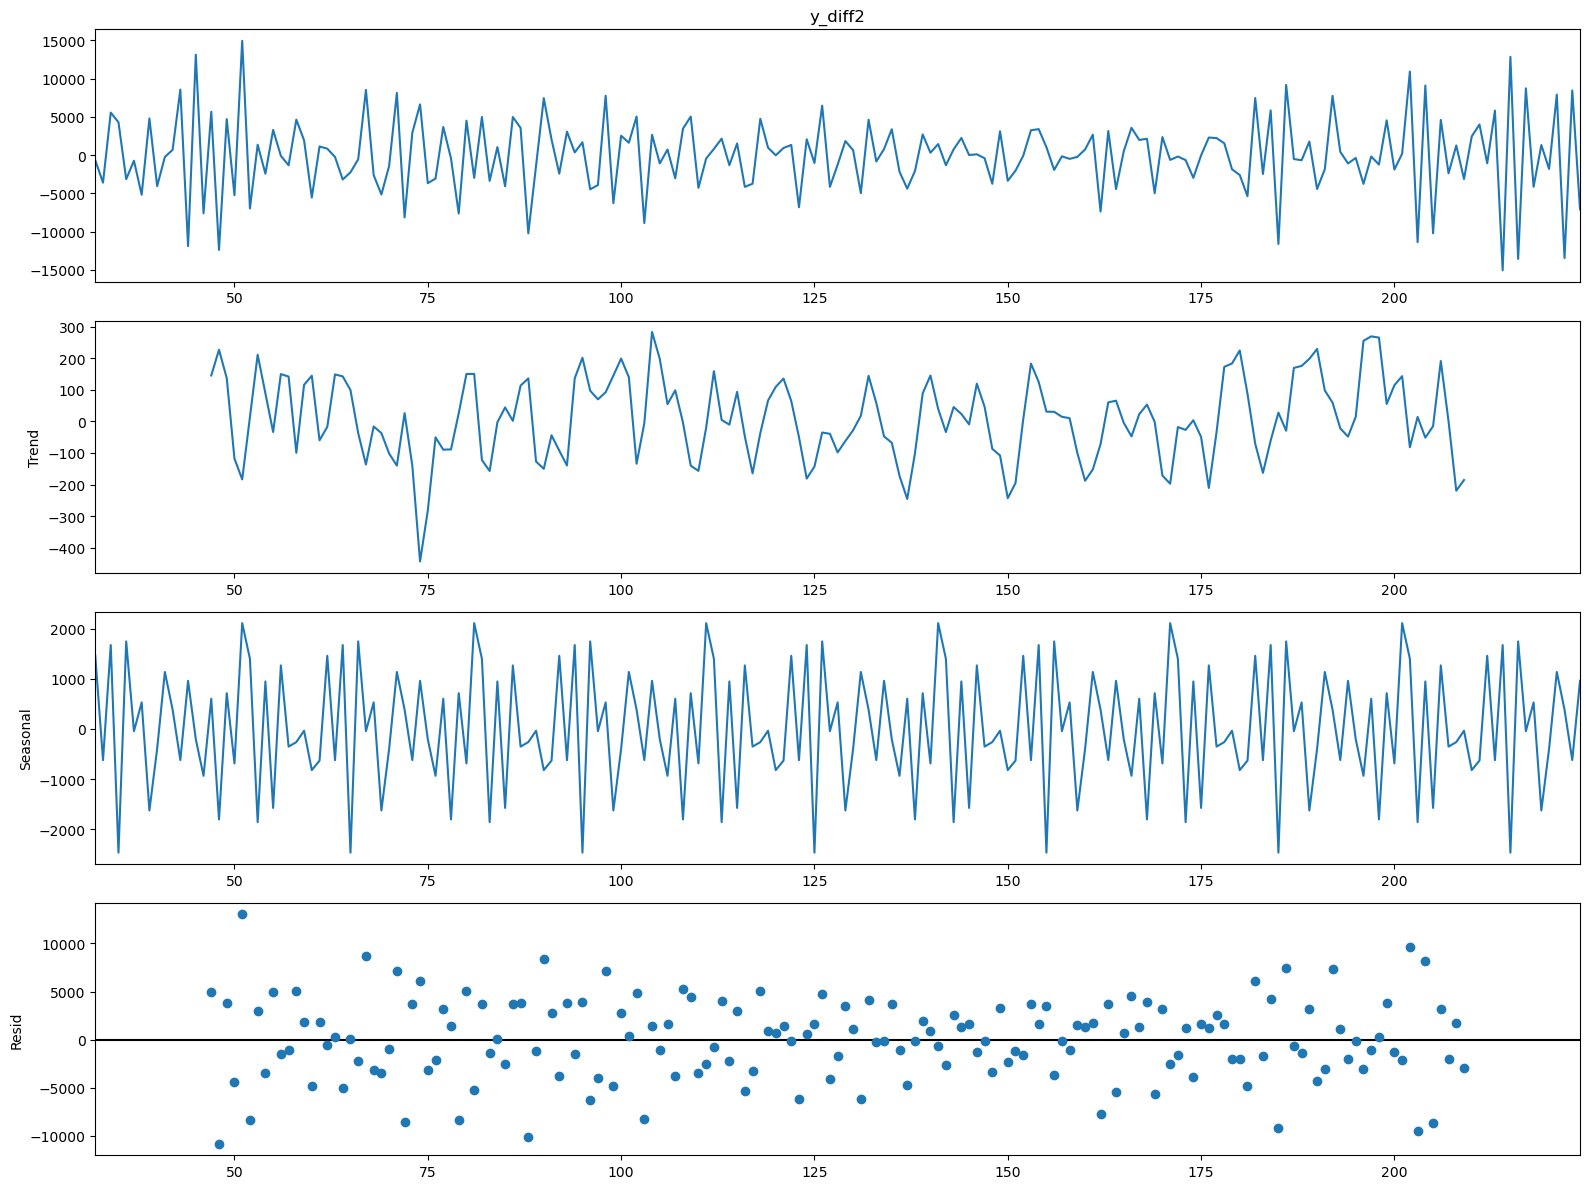

In [8]:
df['y_diff2'] = df[target] - df[target].shift(1)
target = 'y_diff2'
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(df[target][period+2:], period=period).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df[target][period+2:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. Также, остатки гомоскедастичны 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

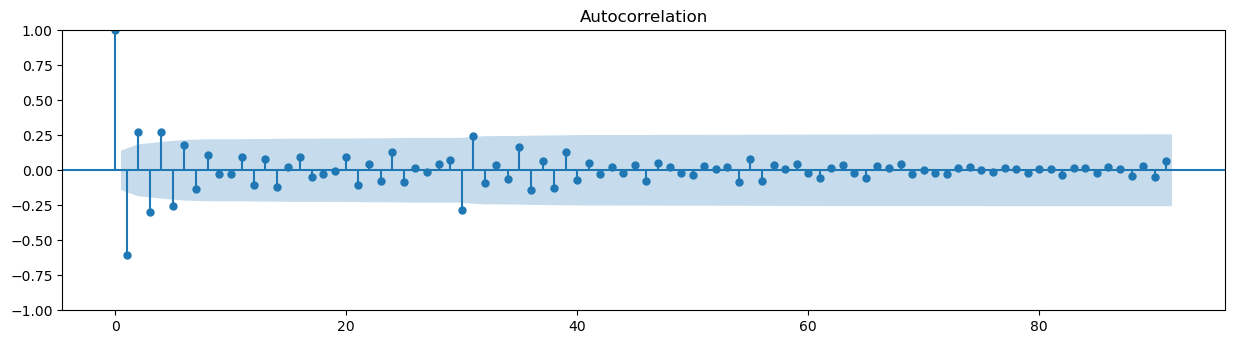

H:\Programs\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


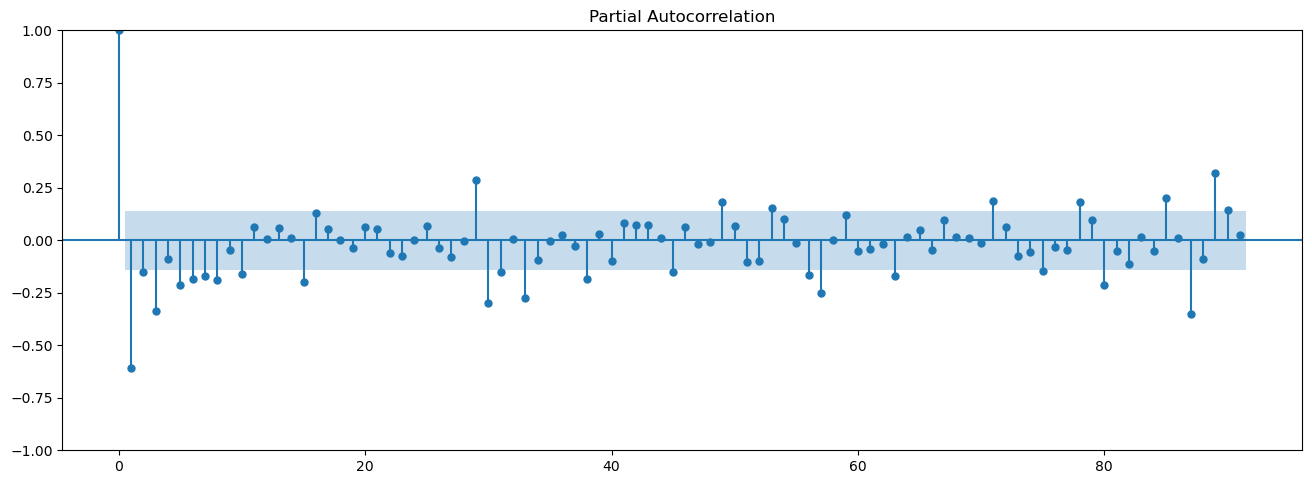

In [9]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df[target][period+2:].values.squeeze(), lags=period*3+1, ax=ax)
plt.show()
# pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df[target][period+2:].values.squeeze(), lags=period*3+1, ax=ax)
plt.show()

Начальные приближения: 

Q=1 - значение для сезонного лага автокорелляции

q=5 - значение для несезонного лага автокорелляции

P=1 - значение для сезонного лага частичной автокорелляции

p=3 - значение для несезонного лага частичной автокорелляции

D=1 - порядок сезонного дифференцирования

d=2 - порядок несезонного дифференцирования

In [10]:
Qs = range(0, 2)
qs = range(1, 6)
Ps = range(0, 2)
ps = range(1, 4)
D=1
d=2

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

Переберём различные значения P,Q,p,q до начальных приближений, и найдём лучшую модель по критерию Акаике.

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df['y'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], period)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: total: 23min 54s
Wall time: 8min 42s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
27  (2, 2, 1, 1)  3745.215321
47  (3, 2, 1, 1)  3747.222903
31  (2, 3, 1, 1)  3749.554075
3   (1, 1, 1, 1)  3750.371044
51  (3, 3, 1, 1)  3751.549450


Лучшая модель:

In [14]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  225
Model:             SARIMAX(2, 2, 2)x(1, 1, [1], 30)   Log Likelihood               -1865.608
Date:                              Tue, 28 Feb 2023   AIC                           3745.215
Time:                                      11:46:04   BIC                           3768.054
Sample:                                           0   HQIC                          3754.464
                                              - 225                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5603      0.068     -8.234      0.000      -0.694      -0.427
ar.L2          0.38

Её остатки:

Критерий Стьюдента: p=0.022475
Критерий Дики-Фуллера: p=0.000000


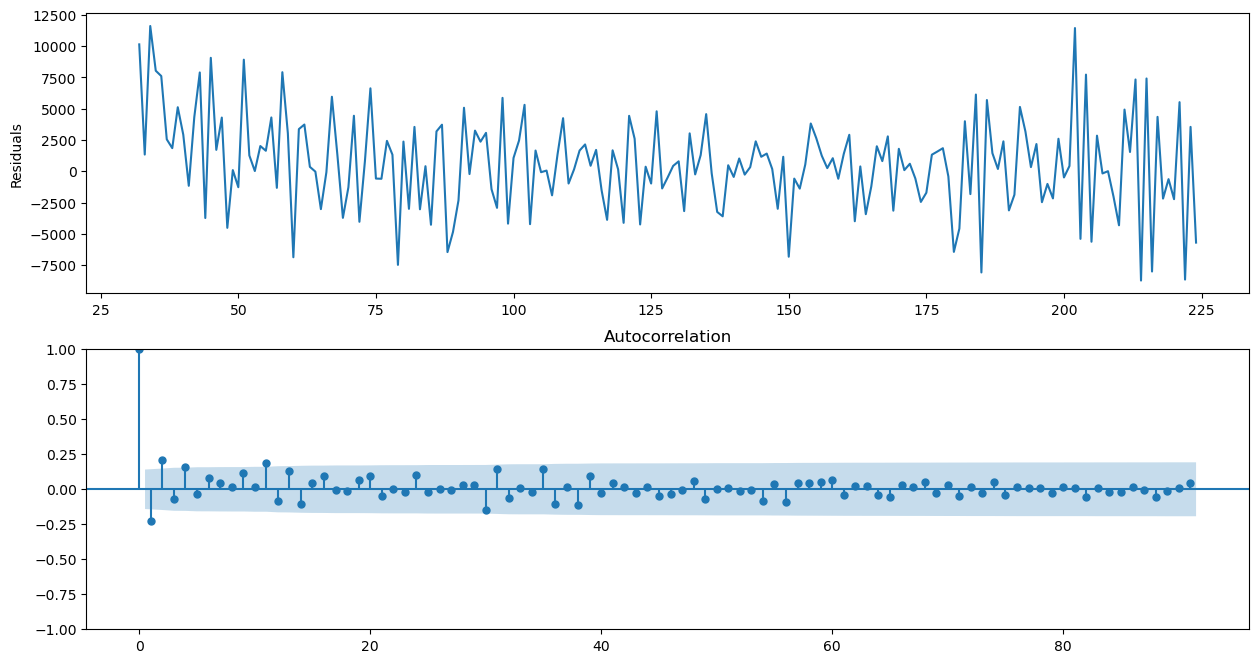

In [15]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[period+2:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[period+2:].values.squeeze(), lags=period*3+1, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[period+2:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[period+2:])[1])

Остатки несмещены (подтверждается критерием Стьюдента на уровне значимости 0.05) стационарны (подтверждается критерием Дики-Фуллера и визуально). Небольшая автокорелляция осталась, но полностью избавиться от неё, не задавая слишком большие значения P,Q,p,q,D,d не получается.
Посмотрим, насколько хорошо модель описывает данные:

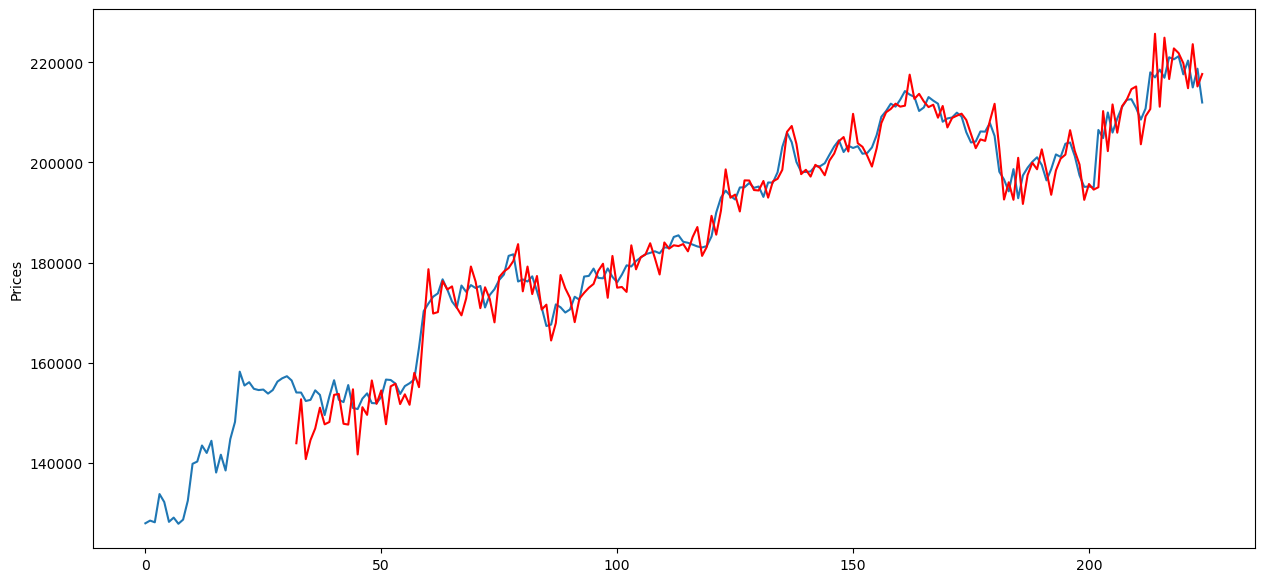

In [16]:
df['model'] = best_model.fittedvalues
plt.figure(figsize=(15,7))
df['y'].plot()
df.model[period+2:].plot(color='r')
plt.ylabel('Prices')
plt.show()

### Прогноз

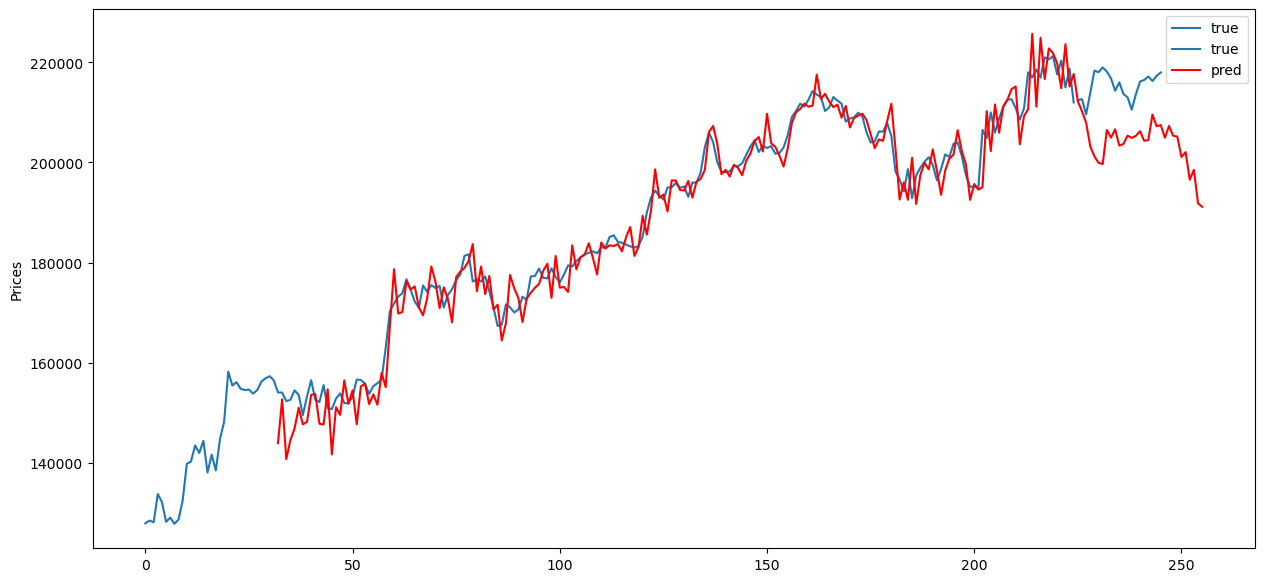

In [17]:
df2 = df[['y']]
date_list = [x for x in range(225,225+31)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = best_model.predict(start=period+2, end=(225+31))

plt.figure(figsize=(15,7))
df2.y.plot(label='true')
df_test.y.plot(color=u'#1f77b4', label='true')
df2.forecast.plot(color='r', label='pred')
plt.ylabel('Prices')
plt.legend()
plt.show()

Предсказание получилось не очень точным. Модель неплохо предсказала колебания цены, но прогноз оказался меньше чем реальность, и, даже если увеличить прогноз на подходящую константу, прогноз модели как-будто немного запаздывает за реальными колебаниями цены.